# Wild Blueberry Yield Prediction

"The dataset used for predictive modeling was generated by the Wild Blueberry Pollination Simulation Model, which is an open-source, spatially-explicit computer simulation program that enables exploration of how various factors, including plant spatial arrangement, outcrossing and self-pollination, bee species compositions and weather conditions, in isolation and combination, affect pollination efficiency and yield of the wild blueberry agroecosystem. The simulation model has been validated by the field observation and experimental data collected in Maine USA and Canadian Maritimes during the last 30 years and now is a useful tool for hypothesis testing and theory development for wild blueberry pollination researches."

The aim it to predict blueberry yield

Features Unit Description:
- Clonesize m2 The average blueberry clone size in the field
- Honeybee bees/m2/min Honeybee density in the field
- Bumbles bees/m2/min Bumblebee density in the field
- Andrena bees/m2/min Andrena bee density in the field
- Osmia bees/m2/min Osmia bee density in the field
- MaxOfUpperTRange ℃ The highest record of the upper band daily air temperature during the bloom season
- MinOfUpperTRange ℃ The lowest record of the upper band daily air temperature
- AverageOfUpperTRange ℃ The average of the upper band daily air temperature
- MaxOfLowerTRange ℃ The highest record of the lower band daily air temperature
- MinOfLowerTRange ℃ The lowest record of the lower band daily air temperature
- AverageOfLowerTRange ℃ The average of the lower band daily air temperature
- RainingDays Day The total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays Day The average of raining days of the entire bloom season

Resources:
- [Kaggle challenge](https://www.kaggle.com/competitions/playground-series-s3e14/overview)

In [1]:
# importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'axes.titlesize': 18,
    'figure.figsize': (12, 4),
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('colorblind'), 
              rc=theme_parameters)

# Read Data

In [3]:
df = pd.read_csv("./../data/blueberry_train.csv")
df_validation = pd.read_csv("./../data/blueberry_test.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [5]:
df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [6]:
df.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


In [7]:
# drop id column
df = df.drop(columns='id', axis=1)

# Eploratory data analysis - EDA

## Features distribution train KDEs



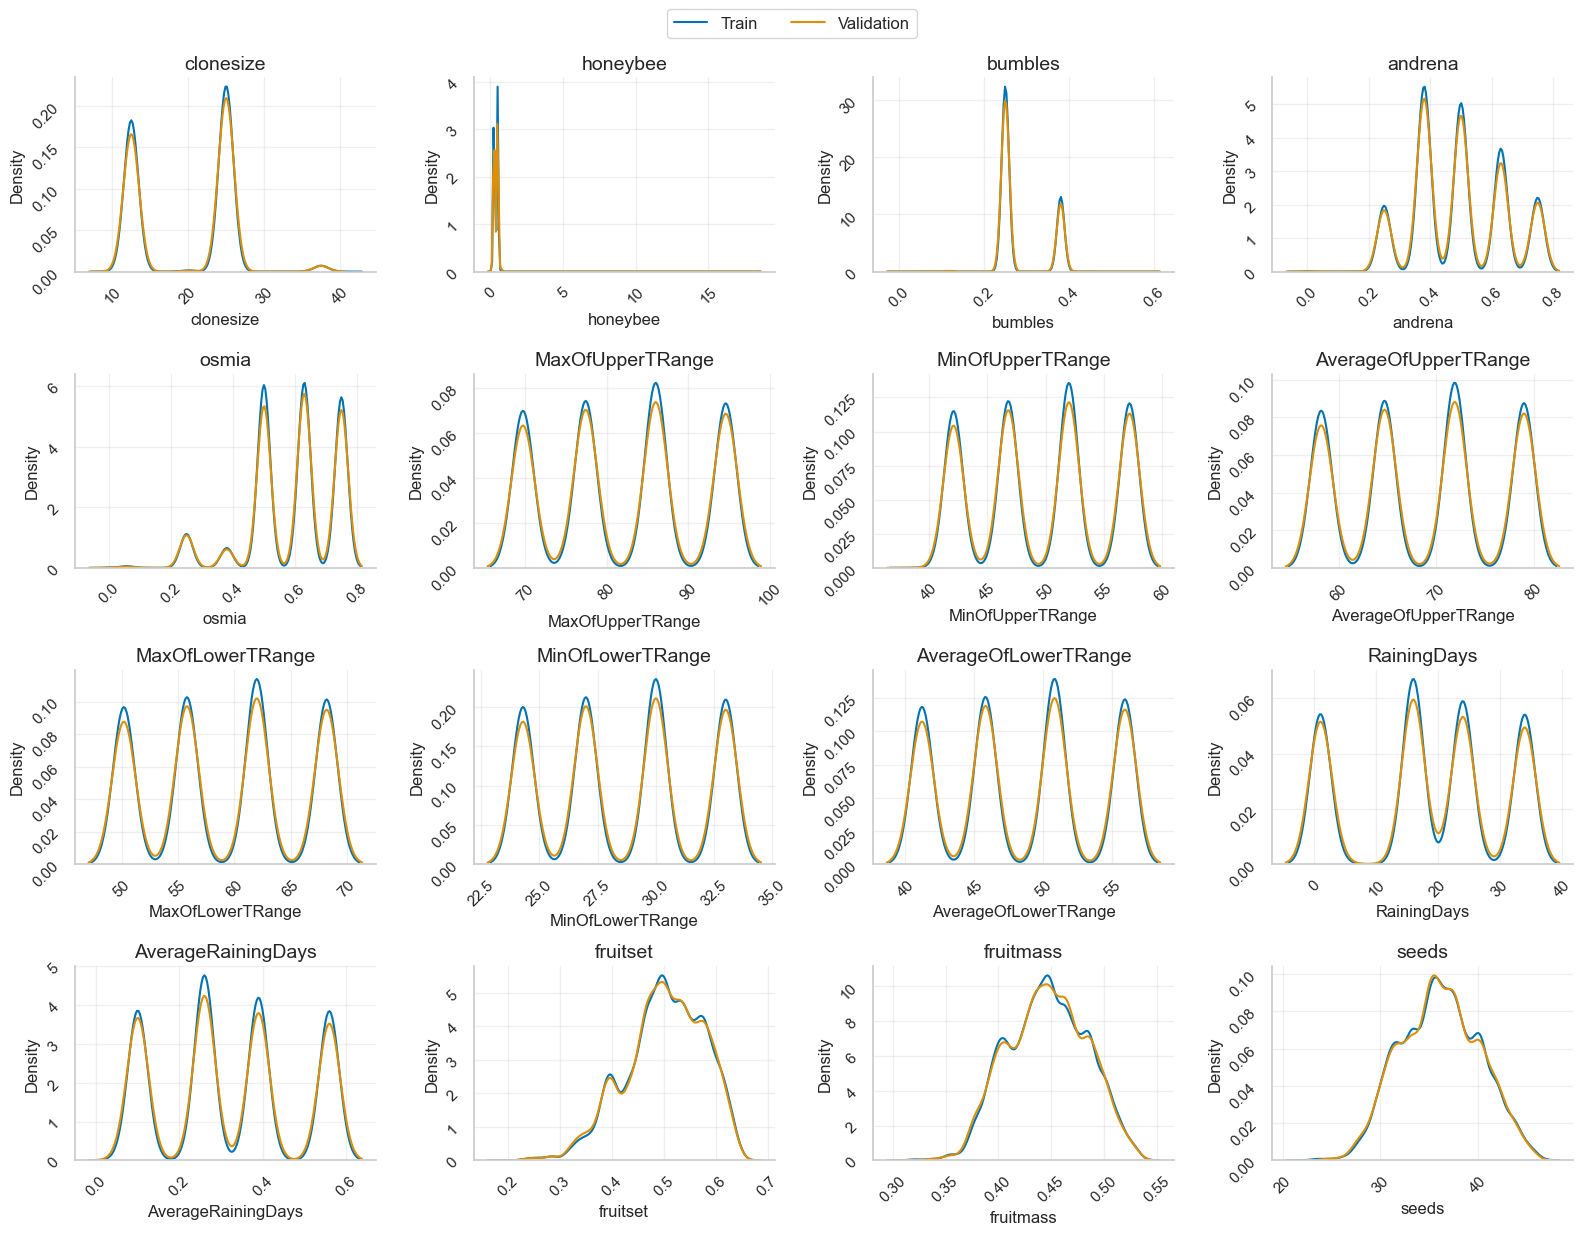

In [8]:
figure, ax = plt.subplots(4, 4, figsize=(16, 12))
ax = ax.flatten()

for index, col_name in enumerate(df.columns[:-1]):
    
    sns.kdeplot(data=df[col_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=df_validation[col_name],
                label='Validation',
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

plt.tight_layout()

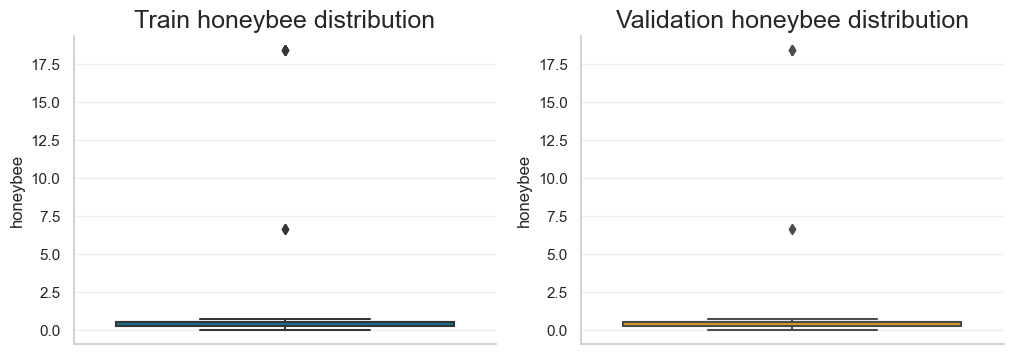

In [9]:
figure, ax = plt.subplots(1, 2)
ax = ax.flatten()

sns.boxplot(data=df, 
            y='honeybee',
            ax=ax[0])

sns.boxplot(data=df_validation,
            y='honeybee',
            ax=ax[1],
            color='orange')

ax[0].set_title('Train honeybee distribution')

ax[1].set_title('Validation honeybee distribution')

plt.show()

In [10]:
df['honeybee'].value_counts().sort_index(ascending=False).head(5)

18.430       5
6.640        3
0.750      110
0.537       38
0.500     7832
Name: honeybee, dtype: int64

- Outlyers of honeybees need to be dropped

In [11]:
# dropping values >= 5 both in test and validation
df = df[df['honeybee'] < 5].reset_index()
df_validation = df_validation[df_validation['honeybee'] < 5].reset_index()

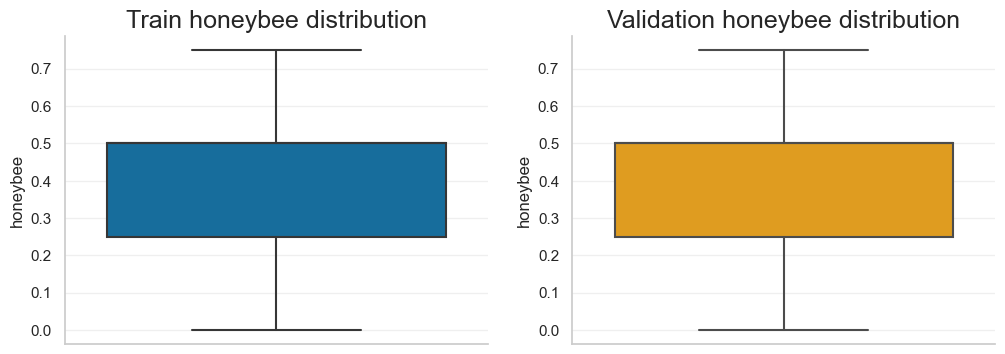

In [12]:
figure, ax = plt.subplots(1, 2)
ax = ax.flatten()

sns.boxplot(data=df, 
            y='honeybee',
            ax=ax[0])

sns.boxplot(data=df_validation,
            y='honeybee',
            ax=ax[1],
            color='orange')

ax[0].set_title('Train honeybee distribution')

ax[1].set_title('Validation honeybee distribution')

plt.show()

- The distribution od the features is consistend between train and validation sets

## Label distribution KDE

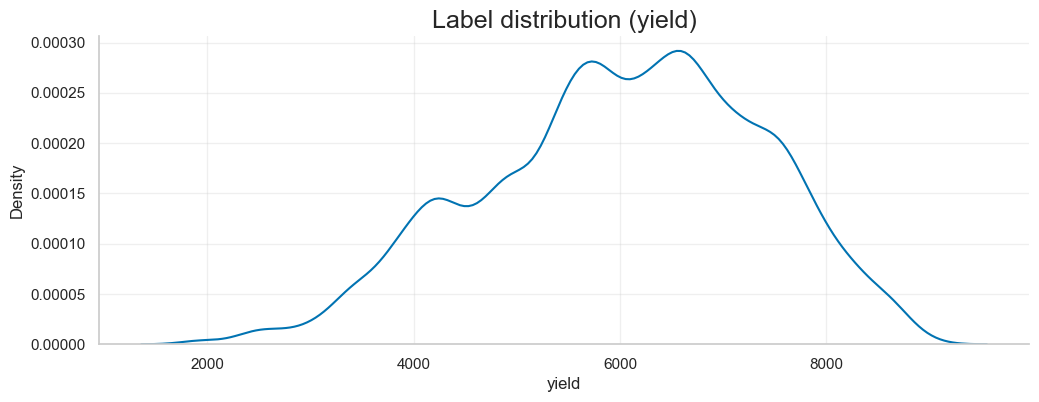

In [13]:
sns.kdeplot(data=df['yield'],
            label='Train')

plt.title('Label distribution (yield)')

plt.show()

The distribution of the label yield looks similar to the distribution of the features 'fruitset', 'fruitmass' and 'seeds'. Since these features are not described (see notebook intro) we can hypotesize that they have been inferred from the label yield.

## Pearson Correlation

In [14]:
# Generate correlation matrix
correlation_train = df.corr(method='pearson')

In [15]:
# Generate a mask for the upper triangle
correlation_mask = np.triu(np.ones_like(correlation_train, dtype=bool))

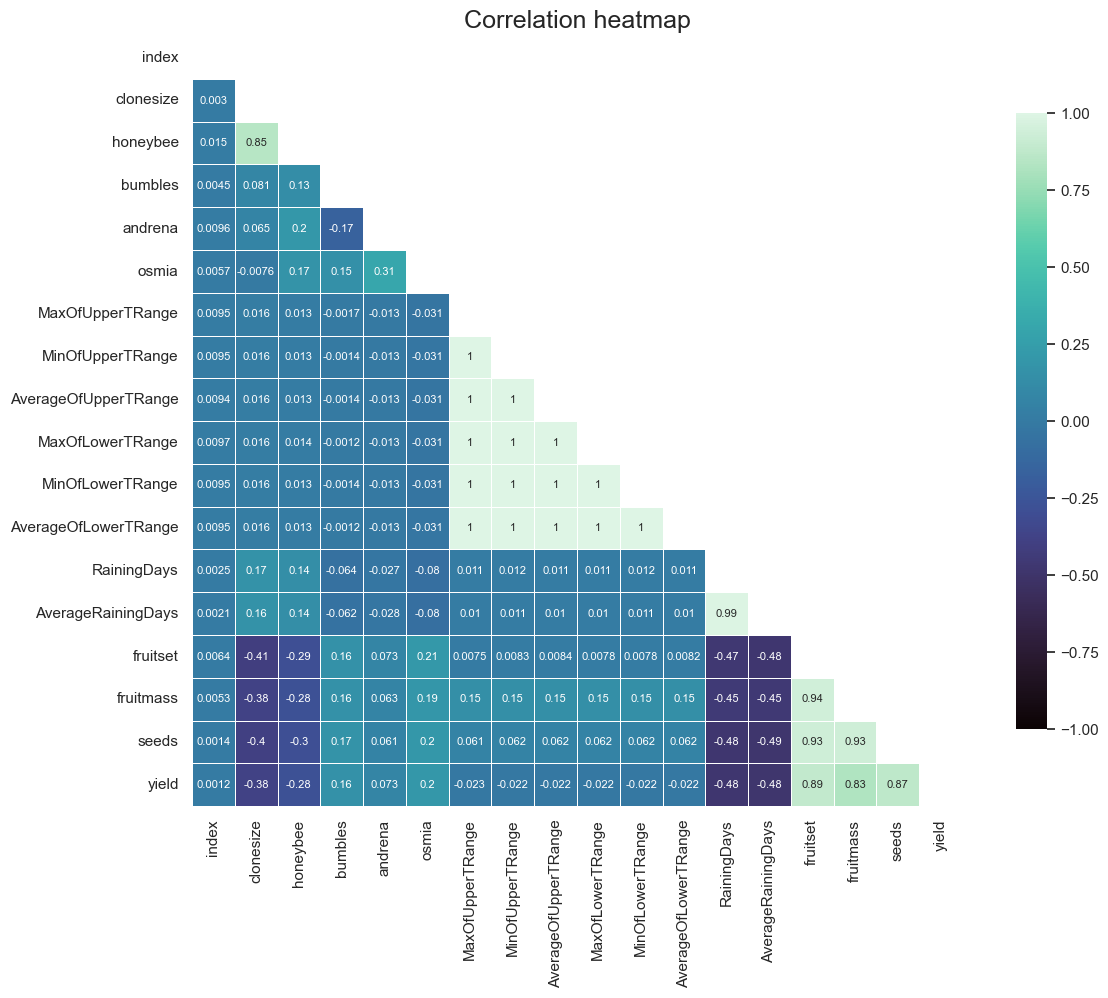

In [17]:
figure, ax = plt.subplots(figsize=(14, 10))

ax = sns.heatmap(correlation_train, 
            mask=correlation_mask, 
            cmap='mako',
            vmax=1.0, 
            vmin=-1.0, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            annot_kws={'fontsize': 8},
            cbar_kws={"shrink":.8, 'orientation':'vertical'})


ax.set_title('Correlation heatmap')

plt.show()

- The correlation matrix shows a very similar and a high correlation behaviour between the features 'fruitset', 'fruitmass' and 'seeds and the lable 'yield', thus the above hypotesis was quite likely correct
- The feature 'clonesize' and 'honeybee' looks to be positively correlated (0.85), we can hypotesize that honeybees are attracted to blueberry cultivation with higher clonesize (maybe because the domestication of honeybees). Anyway, this doesn't appear to translate into a highet yield
- The temperature measures are duplicated, it's enough to keep just one
- Same with AverageRainingDays and RainingDays. Dropping AverageRainingDays

 ## Pairplot
 
 Plotting pairplots between main features to look at potential non-linear relaationships

In [18]:
df.columns

Index(['index', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

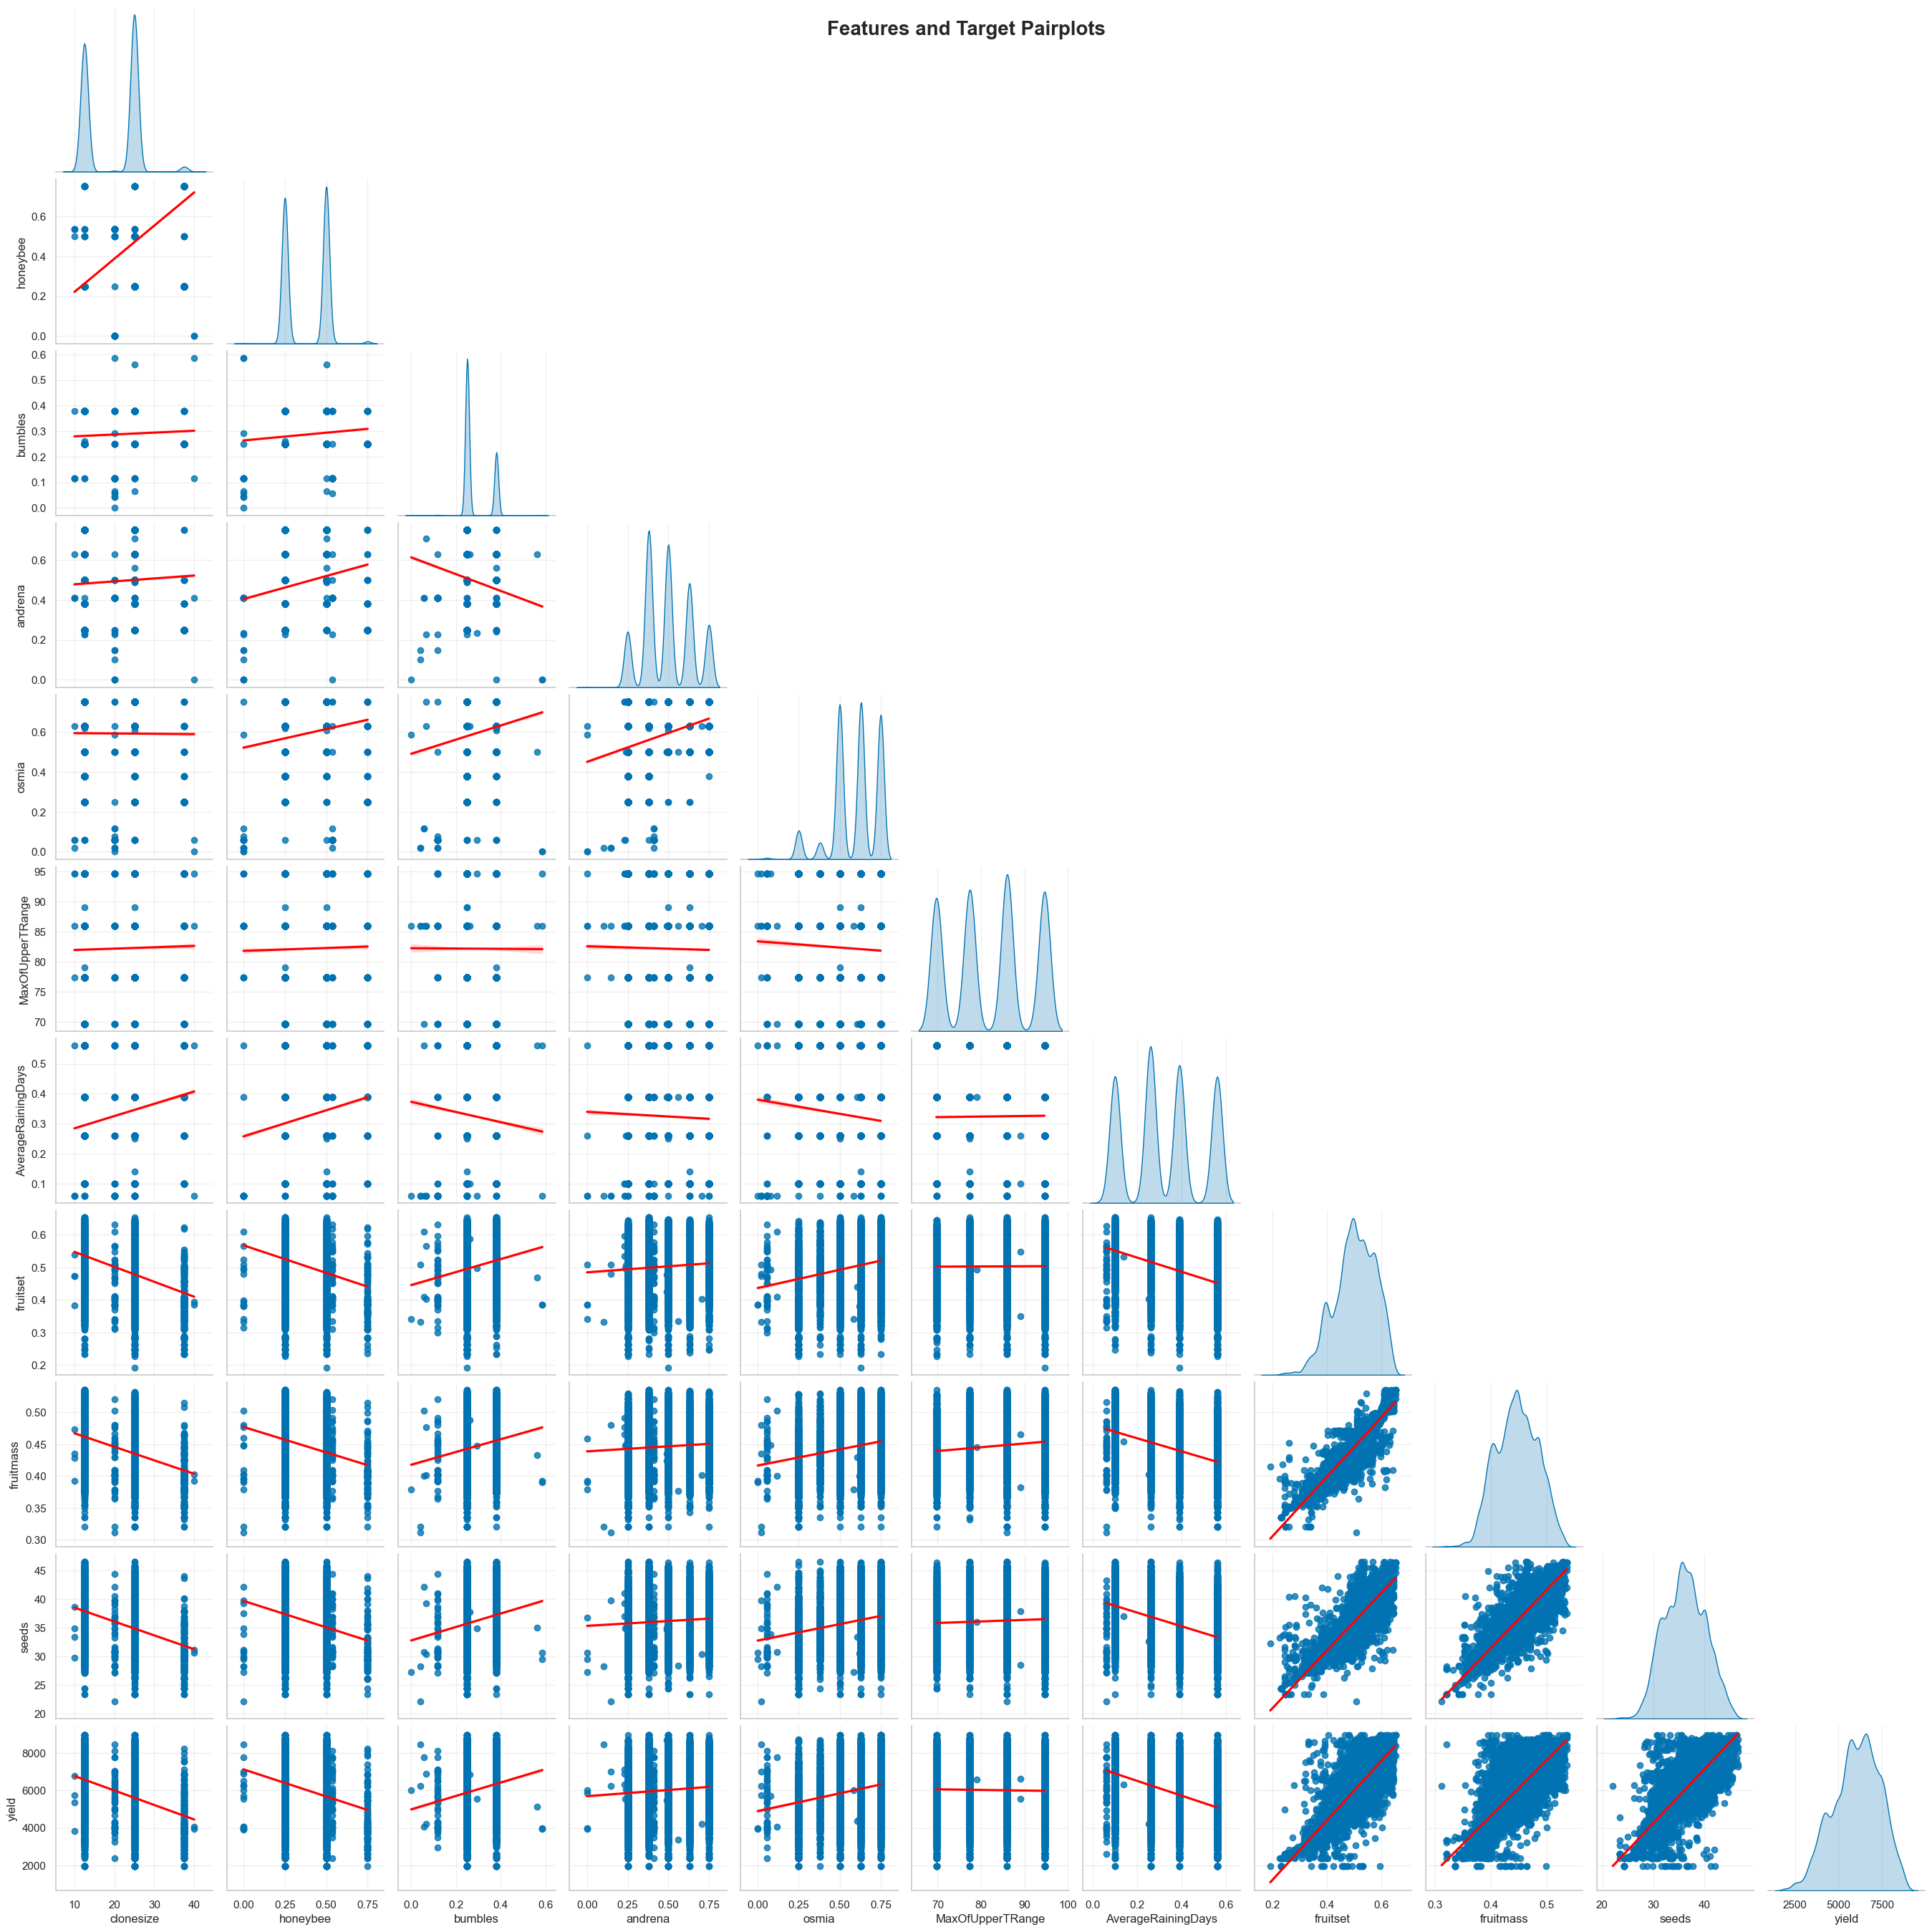

In [22]:
sns.pairplot(df[['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']],
             kind="reg",
             diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}},
             corner=True)

plt.suptitle('Features and Target Pairplots', 
             fontsize=20, 
             fontweight='bold')

plt.show()

The data are probably AI generated. Doesn't look like there are particular non-linar relationships between features.